#  🪁🦄 **Toy dataset multi-class classification** 🧸🏰

chapter 2: **PyTorch Neural Network Classification**

https://www.youtube.com/watch?v=Z_ikDlimN6A

# Imports

In [1]:
import torch
import sklearn

import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from sklearn.datasets import make_blobs 
from sklearn.model_selection import train_test_split

# Data Preparation

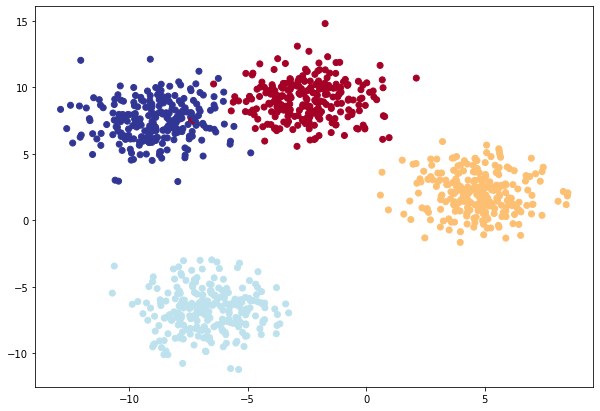

In [2]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42
LEARNING_RATE = 0.1

# 1. Create multi-class data
X, y = make_blobs(n_samples=1000,
                  n_features=NUM_FEATURES,
                  centers=NUM_CLASSES,
                  cluster_std=1.5, 
                  random_state=RANDOM_SEED)

# 2. Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

# 3. Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, 
                                                    random_state=RANDOM_SEED)

# 4. Plot data (visualize, visualize, visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

# Model Building

### binary classification
*  **Output:**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1 lable
*  **Activation:**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ReLU
*  **Loss Function:**&nbsp;&nbsp;&nbsp;&nbsp;nn.BCELoss
*  **Rouding:**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;torch.round


### multiclass classification:
*  **Output:**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1 lable per class
*  **Activation:**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;SoftMax
*  **Loss Function:**&nbsp;&nbsp;&nbsp;&nbsp;nn.CrossEntropyLoss
*  **Rouding:**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;torch.argmax

In [3]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
# multi-class classification model implementation
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):

    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(input_features, hidden_units),
        # nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        # nn.ReLU(),
        nn.Linear(hidden_units, output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [5]:
# Create an instance of the model
model = BlobModel(input_features=2,
                  output_features=4,
                  hidden_units=8)

# send model to target device
model.to(device)

print(f'''{model} device: {next(model.parameters()).device}''')

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
) device: cuda:0


# Prediction with untrained model

In [6]:
# Calculate accuracy - % of right predictions
def accuracy_fn(y_pred, y_true):
  correct = torch.eq(y_true, y_pred).sum().item() 
  acc = (correct/len(y_pred)) * 100
  return acc

In [7]:
model.eval()
with torch.inference_mode():
  y_logits = model(X_test.to(device))

# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)

print(
f'''
y logits:
{y_logits[:10]} 

y prediction probabilities:
{y_pred_probs[:10]}

y prediction lables:
{y_preds[:10]}

y test:
{y_test[:10]}

accuracy: {accuracy_fn(y_preds.cpu(), y_test.cpu())}
'''
)


y logits:
tensor([[-0.1620, -0.3030, -0.3646, -1.1263],
        [ 1.1759, -1.5306,  0.8389, -2.4275],
        [ 0.8704, -0.5406,  1.0571,  0.1966],
        [-0.0881, -0.1986, -0.1786, -0.6335],
        [ 0.3870, -1.0416, -0.0339, -2.4303],
        [ 1.3675, -1.7386,  0.9888, -2.7193],
        [ 0.6715, -0.3388,  0.8916,  0.4534],
        [ 0.5887, -1.1520,  0.1993, -2.3816],
        [ 1.1785, -0.8125,  1.3417, -0.0677],
        [ 0.5105, -1.0991,  0.1159, -2.3675]], device='cuda:0') 

y prediction probabilities:
tensor([[0.3261, 0.2832, 0.2663, 0.1243],
        [0.5531, 0.0369, 0.3949, 0.0151],
        [0.3380, 0.0824, 0.4073, 0.1723],
        [0.2951, 0.2643, 0.2696, 0.1710],
        [0.5113, 0.1225, 0.3356, 0.0306],
        [0.5726, 0.0256, 0.3921, 0.0096],
        [0.2929, 0.1066, 0.3650, 0.2355],
        [0.5252, 0.0921, 0.3558, 0.0269],
        [0.3844, 0.0525, 0.4526, 0.1106],
        [0.5181, 0.1036, 0.3492, 0.0291]], device='cuda:0')

y prediction lables:
tensor([0, 0, 2, 0, 0

# Model Training

In [8]:
# Reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setup loss function 
loss_fn = nn.CrossEntropyLoss()

# Setup optimizer 
optimizer = torch.optim.SGD(params=model.parameters(), lr=LEARNING_RATE)

# Put data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Set number of epochs 
epochs = 200

# Loop through data
for epoch in range(epochs + 1):
    model.train()

    # 1. Forward pass
    y_logits = model(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. Calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_pred, y_train)
  
    # 3. Update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # 2. Calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(test_preds, y_test)
    
    # Print out what's happenin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%\n")

Epoch: 0 | Loss: 1.7729, Acc: 63.75% | Test loss: 0.7413, Test acc: 71.00%

Epoch: 10 | Loss: 0.1475, Acc: 99.12% | Test loss: 0.1326, Test acc: 98.50%

Epoch: 20 | Loss: 0.0833, Acc: 99.12% | Test loss: 0.0745, Test acc: 99.50%

Epoch: 30 | Loss: 0.0617, Acc: 99.00% | Test loss: 0.0537, Test acc: 99.50%

Epoch: 40 | Loss: 0.0513, Acc: 99.00% | Test loss: 0.0433, Test acc: 99.50%

Epoch: 50 | Loss: 0.0452, Acc: 99.00% | Test loss: 0.0372, Test acc: 99.50%

Epoch: 60 | Loss: 0.0412, Acc: 99.00% | Test loss: 0.0331, Test acc: 99.50%

Epoch: 70 | Loss: 0.0385, Acc: 99.00% | Test loss: 0.0302, Test acc: 99.50%

Epoch: 80 | Loss: 0.0365, Acc: 99.00% | Test loss: 0.0281, Test acc: 99.50%

Epoch: 90 | Loss: 0.0350, Acc: 99.00% | Test loss: 0.0264, Test acc: 99.50%

Epoch: 100 | Loss: 0.0338, Acc: 99.00% | Test loss: 0.0250, Test acc: 99.50%

Epoch: 110 | Loss: 0.0328, Acc: 99.00% | Test loss: 0.0240, Test acc: 99.50%

Epoch: 120 | Loss: 0.0320, Acc: 99.00% | Test loss: 0.0230, Test acc: 99.50

# Prediction with trained model

In [9]:
model.eval()
with torch.inference_mode():
  y_logits = model(X_test.to(device))

# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)

print(
f'''
y logits:
{y_logits[:10]} 

y prediction probabilities:
{y_pred_probs[:10]}

y prediction lables:
{y_preds[:10]}

y test:
{y_test[:10]}

accuracy: {accuracy_fn(y_preds.cpu(), y_test.cpu())}
'''
)


y logits:
tensor([[  7.8607,  15.4381, -13.8721,  -8.8256],
        [  4.5339, -16.9161,   2.9091,  11.4933],
        [-12.2146, -23.0333,  21.1742,  11.1497],
        [  3.4290,  10.3753,  -7.5843,  -6.6615],
        [ 12.2891,   6.6308, -14.2981,  -1.9096],
        [  4.8508, -20.9367,   4.3107,  14.2079],
        [-12.1973, -18.5918,  19.2819,   8.2463],
        [  9.9457,   0.3329,  -9.4439,   1.6053],
        [-13.2474, -30.6899,  25.3752,  15.8944],
        [ 10.6065,   2.5839, -11.0134,   0.3032]], device='cuda:0') 

y prediction probabilities:
tensor([[5.1158e-04, 9.9949e-01, 1.8642e-13, 2.8986e-11],
        [9.4857e-04, 4.5861e-13, 1.8682e-04, 9.9886e-01],
        [3.1579e-15, 6.3229e-20, 9.9996e-01, 4.4302e-05],
        [9.6126e-04, 9.9904e-01, 1.5844e-08, 3.9869e-08],
        [9.9652e-01, 3.4766e-03, 2.8302e-12, 6.7935e-07],
        [8.6338e-05, 5.4555e-16, 5.0308e-05, 9.9986e-01],
        [2.1318e-14, 3.5618e-17, 9.9998e-01, 1.6118e-05],
        [9.9969e-01, 6.6849e-05, 3.

# Decision Boundary

In [10]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

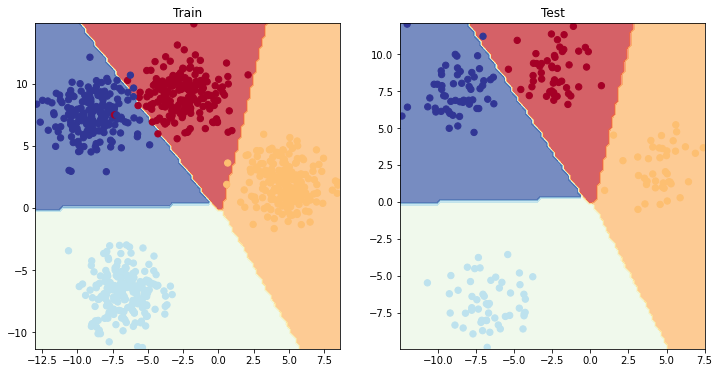

In [11]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)

plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

# Evaluation Metrics

In [12]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 15.5 MB/s 


In [13]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy().to(device)

# Calculuate accuracy
torchmetric_accuracy(y_preds, y_test)

tensor(0.9950, device='cuda:0')